# Introduction to Sequential Parameter Optimization
## Expected Improvement

## 1 Example: `Spot` and the 1-dim Sphere Function

In [1]:
import numpy as np
from math import inf
from spotPython.fun.objectivefunctions import analytical
from spotPython.spot import spot
from scipy.optimize import shgo
from scipy.optimize import direct
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

### The Objective Function: 1-dim Sphere

* The `spotPython` package provides several classes of objective functions.
* We will use an analytical objective function, i.e., a function that can be described by a (closed) formula:
   $$f(x) = x^2 $$

In [2]:
fun = analytical().fun_sphere

In [3]:
fun = analytical().fun_sphere
fun_control = {"sigma": 0,
               "seed": 123}

* The size of the `lower` bound vector determines the problem dimension.
* Here we will use `np.array([-1])`, i.e., a one-dim function.

In [4]:
spot_1 = spot.Spot(fun=fun,
                   lower = np.array([-1]),
                   upper = np.array([1]))

spot_1.run()

### Results

In [5]:
spot_1.print_results()

min y: 4.897545259852824e-10
x0: 2.2130398233770724e-05


[['x0', 2.2130398233770724e-05]]

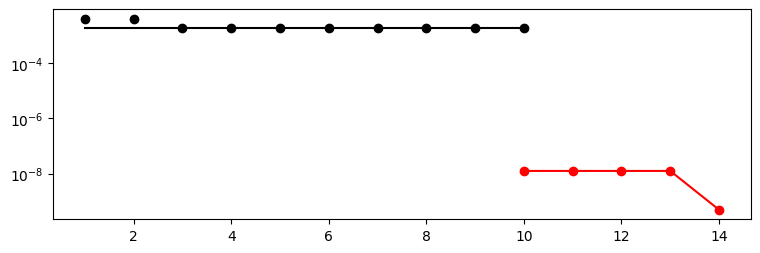

In [6]:
spot_1.plot_progress(log_y=True)

## 2 Same, but with EI as infill_criterion

In [7]:
spot_1_ei = spot.Spot(fun=fun,
                   lower = np.array([-1]),
                   upper = np.array([1]),
                   infill_criterion = "ei")
spot_1_ei.run()

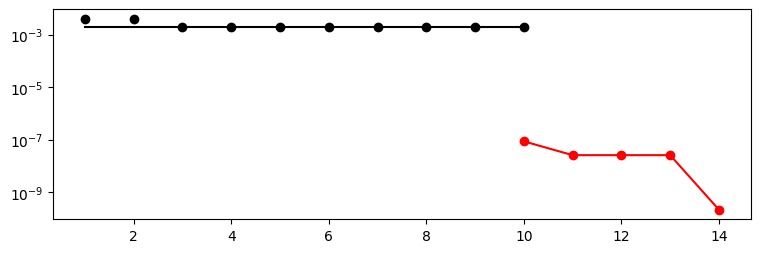

In [8]:
spot_1_ei.plot_progress(log_y=True)

In [9]:
spot_1_ei.print_results()

min y: 2.1963022660037201e-10
x0: 1.4819926673245452e-05


[['x0', 1.4819926673245452e-05]]

# Non-isotropic Kriging

In [10]:
spot_2_ei_noniso = spot.Spot(fun=fun,
                   lower = np.array([-1, -1]),
                   upper = np.array([1, 1]),
                   fun_evals = 20,
                   fun_repeats = 1,
                   max_time = inf,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type=["num"],
                   infill_criterion = "ei",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models=True,
                   fun_control = fun_control,
                   design_control={"init_size": 10,
                                   "repeats": 1},
                   surrogate_control={"noise": False,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": 2,
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 1000,
                                      })
spot_2_ei_noniso.run()

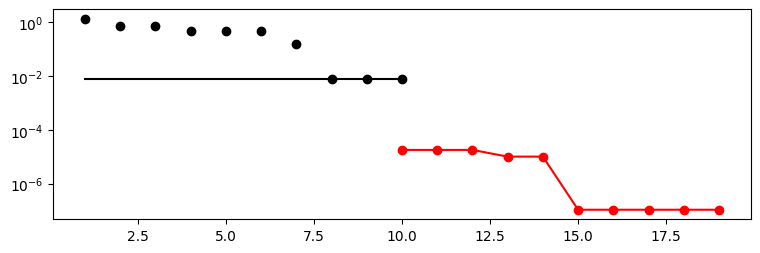

In [11]:
spot_2_ei_noniso.plot_progress(log_y=True)

In [12]:
spot_2_ei_noniso.print_results()

min y: 1.088759927339735e-07
x0: -0.0002833471276146305
x1: 0.00016908695398081962


[['x0', -0.0002833471276146305], ['x1', 0.00016908695398081962]]

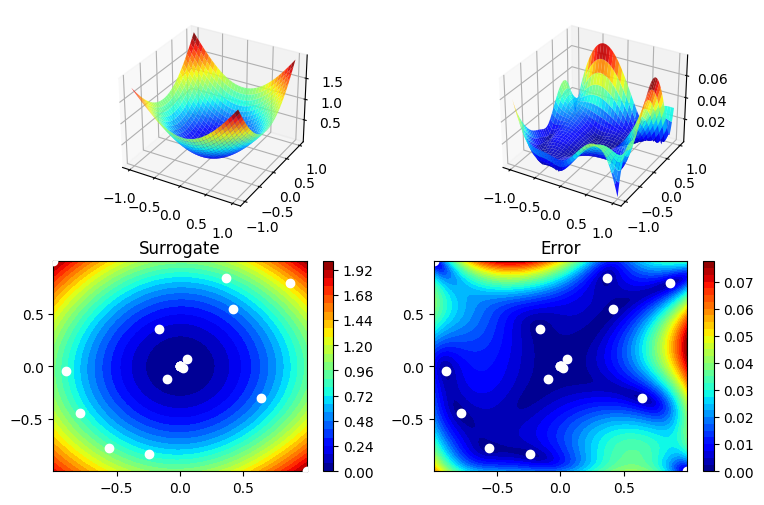

In [13]:
spot_2_ei_noniso.surrogate.plot()

# Using `sklearn` Surrogates

# The spot Loop

The `spot` loop consists of the following steps:

1. Init: Build initial design $X$
2. Evaluate initial design on real objective $f$: $y = f(X)$
3. Build surrogate: $S = S(X,y)$
4. Optimize on surrogate: $X_0 =  \text{optimize}(S)$
5. Evaluate on real objective: $y_0 = f(X_0)$
6. Impute (Infill) new points: $X = X \cup X_0$, $y = y \cup y_0$.
7. Got 3.

The `spot` loop is implemented in `R` as follows:

![Visual representation of the model based search with SPOT. Taken from: Bartz-Beielstein, T., and Zaefferer, M. Hyperparameter tuning approaches. In Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide, E. Bartz, T. Bartz-Beielstein, M. Zaefferer, and O. Mersmann, Eds. Springer, 2022, ch. 4, pp. 67–114. ](figures/spotModel.png)

# spot: The Initial Model

#### Example: Modifying the initial design size

This is the "Example: Modifying the initial design size"  from Chapter 4.5.1 in [bart21i].

In [14]:
spot_ei = spot.Spot(fun=fun,
               lower = np.array([-1,-1]),
               upper= np.array([1,1]),
               design_control={"init_size": 5})
spot_ei.run()

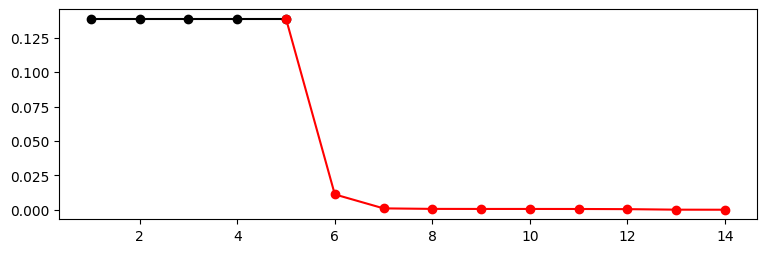

In [15]:
spot_ei.plot_progress()

In [16]:
np.min(spot_1.y), np.min(spot_ei.y)

(4.897545259852824e-10, 1.881581967484049e-05)

## 1. Init: Build Initial Design

In [17]:
from spotPython.design.spacefilling import spacefilling
from spotPython.build.kriging import Kriging
from spotPython.fun.objectivefunctions import analytical
gen = spacefilling(2)
rng = np.random.RandomState(1)
lower = np.array([-5,-0])
upper = np.array([10,15])
fun = analytical().fun_branin
fun_control = {"sigma": 0,
               "seed": 123}

X = gen.scipy_lhd(10, lower=lower, upper = upper)
print(X)
y = fun(X, fun_control=fun_control)
print(y)

[[ 8.97647221 13.41926847]
 [ 0.66946019  1.22344228]
 [ 5.23614115 13.78185824]
 [ 5.6149825  11.5851384 ]
 [-1.72963184  1.66516096]
 [-4.26945568  7.1325531 ]
 [ 1.26363761 10.17935555]
 [ 2.88779942  8.05508969]
 [-3.39111089  4.15213772]
 [ 7.30131231  5.22275244]]
[128.95676449  31.73474356 172.89678121 126.71295908  64.34349975
  70.16178611  48.71407916  31.77322887  76.91788181  30.69410529]


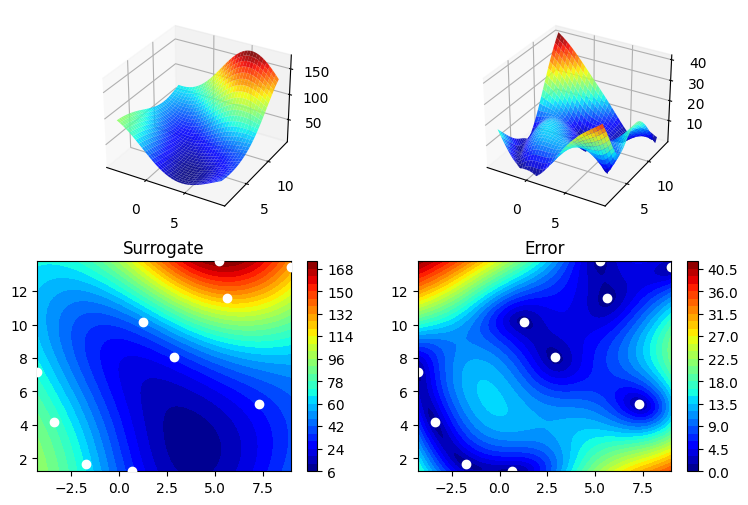

In [18]:
S = Kriging(name='kriging',  seed=123)
S.fit(X, y)
S.plot()


In [19]:
gen = spacefilling(2, seed=123)
X0 = gen.scipy_lhd(3)
gen = spacefilling(2, seed=345)
X1 = gen.scipy_lhd(3)
X2 = gen.scipy_lhd(3)
gen = spacefilling(2, seed=123)
X3 = gen.scipy_lhd(3)
X0, X1, X2, X3

(array([[0.77254938, 0.31539299],
        [0.59321338, 0.93854273],
        [0.27469803, 0.3959685 ]]),
 array([[0.78373509, 0.86811887],
        [0.06692621, 0.6058029 ],
        [0.41374778, 0.00525456]]),
 array([[0.121357  , 0.69043832],
        [0.41906219, 0.32838498],
        [0.86742658, 0.52910374]]),
 array([[0.77254938, 0.31539299],
        [0.59321338, 0.93854273],
        [0.27469803, 0.3959685 ]]))

## 2. Evaluate 

## 3. Build Surrogate

### A Simple Predictor

The code below shows how to use a simple model for prediction.

* Assume that only two (very costly) measurements are available:
  
  1. f(0) = 0.5
  2. f(2) = 2.5

* We are interested in the value at $x_0 = 1$, i.e., $f(x_0 = 1)$, but cannot run an additional, third experiment.

In [20]:
from sklearn import linear_model
X = np.array([[0], [2]])
y = np.array([0.5, 2.5])
S_lm = linear_model.LinearRegression()
S_lm = S_lm.fit(X, y)
X0 = np.array([[1]])
y0 = S_lm.predict(X0)
print(y0)


[1.5]


* Central Idea:
  * Evaluation of the surrogate model `S_lm` is much cheaper (or / and much faster) than running the real-world experiment $f$.

### Gaussian Processes regression: basic introductory example

* Example from [scikit-learn](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html)

* After fitting our model, we see that the hyperparameters of the kernel have been optimized. Now, we will use our kernel to compute the mean prediction of the full dataset and plot the 95% confidence interval.

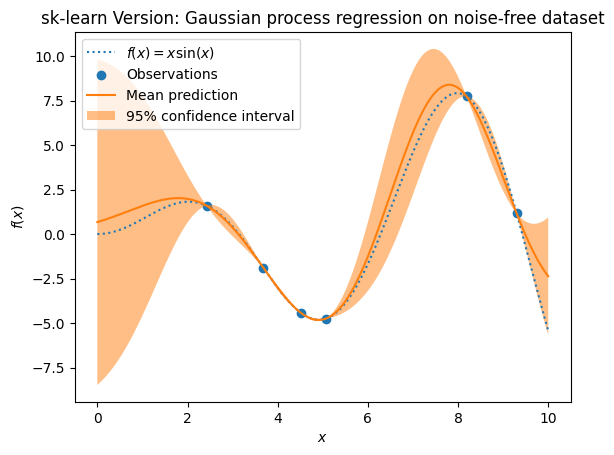

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("sk-learn Version: Gaussian process regression on noise-free dataset")

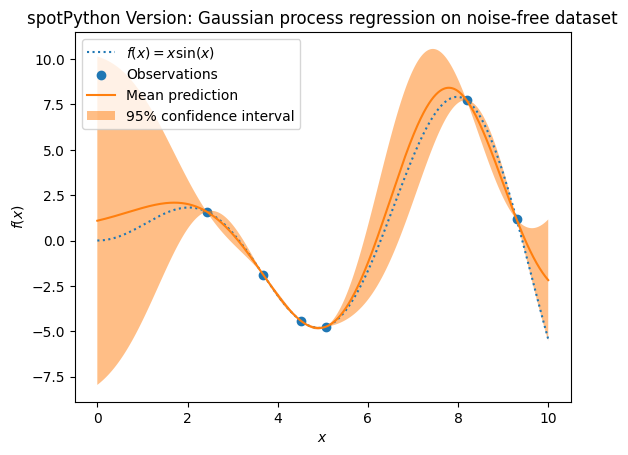

In [22]:
from spotPython.build.kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.RandomState(1)
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]


S = Kriging(name='kriging',  seed=123, log_level=50, cod_type="norm")
S.fit(X_train, y_train)

mean_prediction, std_prediction, ei = S.predict(X, return_val="all")

std_prediction

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("spotPython Version: Gaussian process regression on noise-free dataset")

## The Surrogate: Using scikit-learn models

* Default is the internal `kriging` surrogate.

In [23]:
S_0 = Kriging(name='kriging', seed=123)

* Models from `scikit-learn` can be selected, e.g., Gaussian Process:

In [24]:
# Needed for the sklearn surrogates:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import tree
import pandas as pd

In [25]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
S_GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

* and many more:

In [26]:
S_Tree = DecisionTreeRegressor(random_state=0)
S_LM = linear_model.LinearRegression()
S_Ridge = linear_model.Ridge()
S_RF = RandomForestRegressor(max_depth=2, random_state=0) 


* The scikit-learn GP model `S_GP` is selected.

In [27]:
S = S_GP


In [28]:
isinstance(S, GaussianProcessRegressor)
 

True

In [29]:
from spotPython.fun.objectivefunctions import analytical
fun = analytical().fun_branin
lower = np.array([-5,-0])
upper = np.array([10,15])
design_control={"init_size": 5}
surrogate_control={
            "infill_criterion": None,
            "n_points": 1,
        }
spot_GP = spot.Spot(fun=fun, lower = lower, upper= upper, surrogate=S, 
                    fun_evals = 15, noise = False, log_level = 50,
                    design_control=design_control,
                    surrogate_control=surrogate_control)

spot_GP.run()

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [30]:
spot_GP.y

array([ 69.32459936, 152.38491454, 107.92560483,  24.51465459,
        76.73500031,  86.30425289,  11.00310079,  16.11744326,
         7.28159477,  21.82300166,  10.96088904,   2.95199195,
         3.02909811,   2.10495647,   1.94316675])

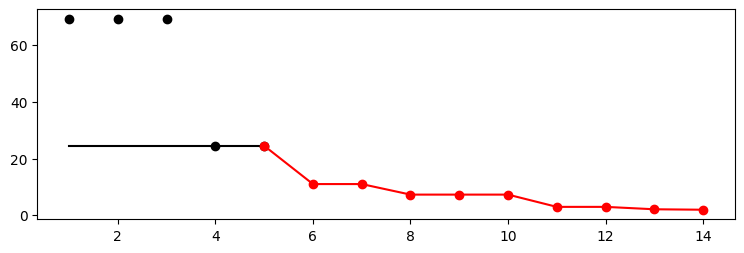

In [31]:
spot_GP.plot_progress()

In [32]:
spot_GP.print_results()

min y: 1.9431667458708617
x0: 10.0
x1: 2.9978494548382284


[['x0', 10.0], ['x1', 2.9978494548382284]]

## Additional Examples

In [33]:
# Needed for the sklearn surrogates:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import tree
import pandas as pd

In [34]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
S_GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [35]:
from spotPython.build.kriging import Kriging
import numpy as np
import spotPython
from spotPython.fun.objectivefunctions import analytical
from spotPython.spot import spot

S_K = Kriging(name='kriging',
              seed=123,
              log_level=50,
              infill_criterion = "y",
              n_theta=1,
              noise=False,
              cod_type="norm")
fun = analytical().fun_sphere
lower = np.array([-1,-1])
upper = np.array([1,1])

design_control={"init_size": 10}
surrogate_control={
            "n_points": 1,
        }
spot_S_K = spot.Spot(fun=fun,
                     lower = lower,
                     upper= upper,
                     surrogate=S_K,
                     fun_evals = 25,
                     noise = False,
                     log_level = 50,
                     design_control=design_control,
                     surrogate_control=surrogate_control)

spot_S_K.run()

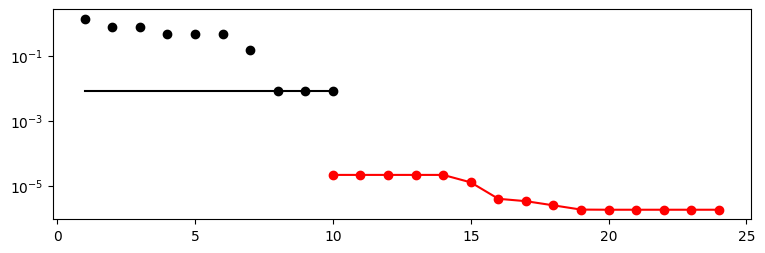

In [36]:
spot_S_K.plot_progress(log_y=True)

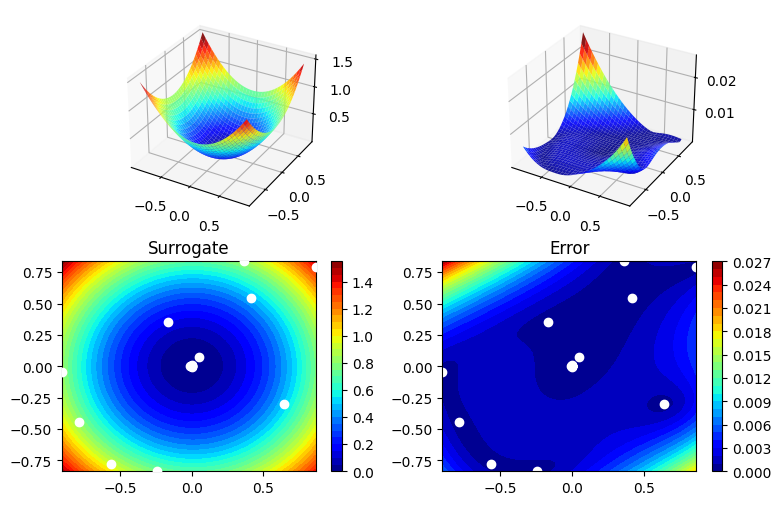

In [37]:
spot_S_K.surrogate.plot()

In [38]:
spot_S_K.print_results()

min y: 1.809224307539433e-06
x0: -0.001330101474082372
x1: 0.0002001358942901893


[['x0', -0.001330101474082372], ['x1', 0.0002001358942901893]]

## 4. Optimize on Surrogate

## 5. Evaluate on Real Objective

## 6. Impute / Infill new Points

# Tests


In [39]:
import numpy as np
from spotPython.spot import spot
from spotPython.fun.objectivefunctions import analytical

fun_sphere = analytical().fun_sphere
spot_1 = spot.Spot(
    fun=fun_sphere,
    lower=np.array([-1, -1]),
    upper=np.array([1, 1]),
    n_points = 2
)

# (S-2) Initial Design:
spot_1.X = spot_1.design.scipy_lhd(
    spot_1.design_control["init_size"], lower=spot_1.lower, upper=spot_1.upper
)
print(spot_1.X)

# (S-3): Eval initial design:
spot_1.y = spot_1.fun(spot_1.X)
print(spot_1.y)

spot_1.surrogate.fit(spot_1.X, spot_1.y)
X0 = spot_1.suggest_new_X()
print(X0)
assert X0.size == spot_1.n_points * spot_1.k

[[ 0.86352963  0.7892358 ]
 [-0.24407197 -0.83687436]
 [ 0.36481882  0.8375811 ]
 [ 0.415331    0.54468512]
 [-0.56395091 -0.77797854]
 [-0.90259409 -0.04899292]
 [-0.16484832  0.35724741]
 [ 0.05170659  0.07401196]
 [-0.78548145 -0.44638164]
 [ 0.64017497 -0.30363301]]
[1.36857656 0.75992983 0.83463487 0.46918172 0.92329124 0.8170764
 0.15480068 0.00815134 0.81623768 0.502017  ]
[[0.00151305 0.00405727]
 [0.00151305 0.00405727]]


# EI: The Famous Schonlau Example

In [40]:
X_train0 = np.array([1, 2, 3, 4, 12]).reshape(-1,1)
X_train = np.linspace(start=0, stop=10, num=5).reshape(-1, 1)

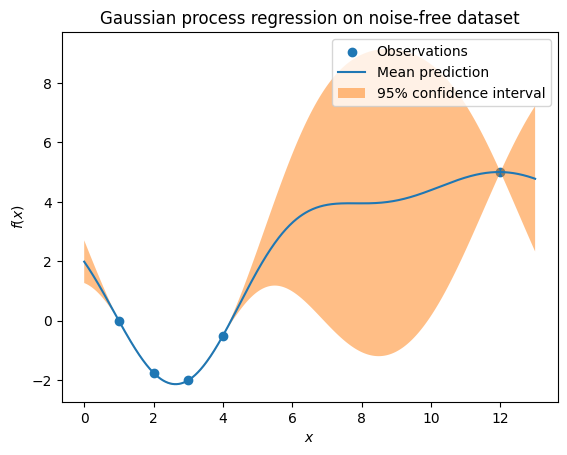

In [41]:
from spotPython.build.kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt

X_train = np.array([1., 2., 3., 4., 12.]).reshape(-1,1)
y_train = np.array([0., -1.75, -2, -0.5, 5.])

S = Kriging(name='kriging',  seed=123, log_level=50, n_theta=1, noise=False, cod_type="norm")
S.fit(X_train, y_train)

X = np.linspace(start=0, stop=13, num=1000).reshape(-1, 1)
mean_prediction, std_prediction, ei = S.predict(X, return_val="all")

plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
if True:
    plt.fill_between(
        X.ravel(),
        mean_prediction - 2 * std_prediction,
        mean_prediction + 2 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

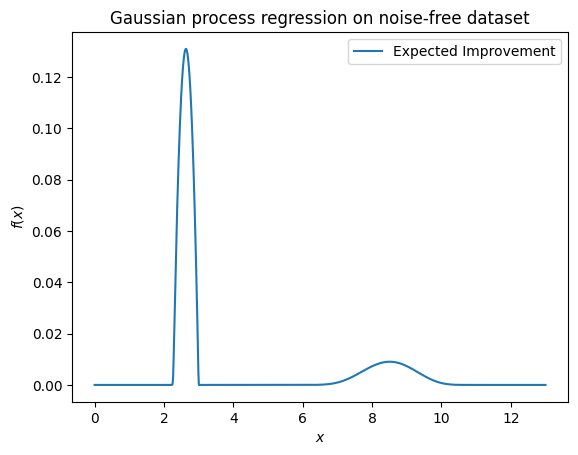

In [42]:
#plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
# plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, -ei, label="Expected Improvement")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [43]:
S.log

{'negLnLike': array([1.20788205]),
 'theta': array([1.09275997]),
 'p': array([2.]),
 'Lambda': array([None], dtype=object)}

# EI: The Forrester Example

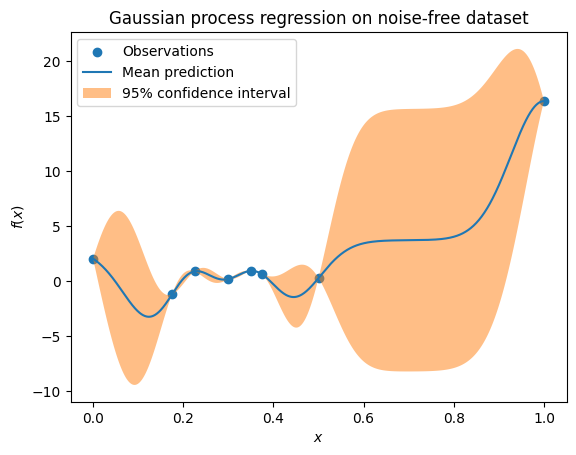

In [44]:
from spotPython.build.kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt
import spotPython
from spotPython.fun.objectivefunctions import analytical
from spotPython.spot import spot

# exact x locations are unknown:
X_train = np.array([0.0, 0.175, 0.225, 0.3, 0.35, 0.375, 0.5,1]).reshape(-1,1)

fun = analytical().fun_forrester
fun_control = {"sigma": 1.0,
               "seed": 123}
y_train = fun(X_train, fun_control=fun_control)

S = Kriging(name='kriging',  seed=123, log_level=50, n_theta=1, noise=False, cod_type="norm")
S.fit(X_train, y_train)

X = np.linspace(start=0, stop=1, num=1000).reshape(-1, 1)
mean_prediction, std_prediction, ei = S.predict(X, return_val="all")

plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
if True:
    plt.fill_between(
        X.ravel(),
        mean_prediction - 2 * std_prediction,
        mean_prediction + 2 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

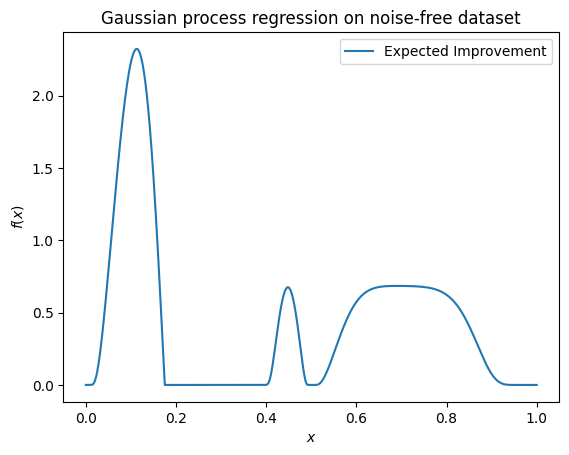

In [45]:
#plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
# plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, -ei, label="Expected Improvement")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

# Noise

[[ 0.63529627]
 [-4.10764204]
 [-0.44071975]
 [ 9.63125638]
 [-8.3518118 ]
 [-3.62418901]
 [ 4.15331   ]
 [ 3.4468512 ]
 [ 6.36049088]
 [-7.77978539]]
[-4.61635371 11.44873209 -0.19988024 91.92791676 68.05926244 12.02926818
 16.2470957   9.12729929 38.4987029  58.38469104]


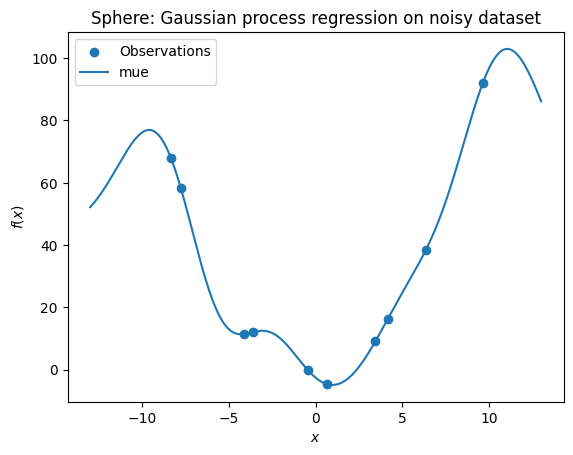

In [46]:
import numpy as np
import spotPython
from spotPython.fun.objectivefunctions import analytical
from spotPython.spot import spot
from spotPython.design.spacefilling import spacefilling
from spotPython.build.kriging import Kriging
import matplotlib.pyplot as plt

gen = spacefilling(1)
rng = np.random.RandomState(1)
lower = np.array([-10])
upper = np.array([10])
fun = analytical().fun_sphere
fun_control = {"sigma": 2,
               "seed": 125}
X = gen.scipy_lhd(10, lower=lower, upper = upper)
print(X)
y = fun(X, fun_control=fun_control)
print(y)
y.shape
X_train = X.reshape(-1,1)
y_train = y

S = Kriging(name='kriging',
            seed=123,
            log_level=50,
            n_theta=1,
            noise=False)
S.fit(X_train, y_train)

X_axis = np.linspace(start=-13, stop=13, num=1000).reshape(-1, 1)
mean_prediction, std_prediction, ei = S.predict(X_axis, return_val="all")

#plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
#plt.plot(X, ei, label="Expected Improvement")
plt.plot(X_axis, mean_prediction, label="mue")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Sphere: Gaussian process regression on noisy dataset")

In [47]:
S.log

{'negLnLike': array([24.69806131]),
 'theta': array([1.31023949]),
 'p': array([2.]),
 'Lambda': array([None], dtype=object)}

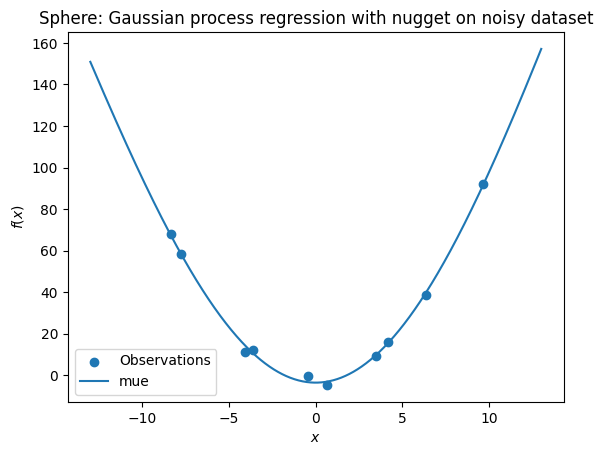

In [48]:
S = Kriging(name='kriging',
            seed=123,
            log_level=50,
            n_theta=1,
            noise=True)
S.fit(X_train, y_train)

X_axis = np.linspace(start=-13, stop=13, num=1000).reshape(-1, 1)
mean_prediction, std_prediction, ei = S.predict(X_axis, return_val="all")

#plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
#plt.plot(X, ei, label="Expected Improvement")
plt.plot(X_axis, mean_prediction, label="mue")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Sphere: Gaussian process regression with nugget on noisy dataset")

In [49]:
S.log

{'negLnLike': array([22.14095646]),
 'theta': array([-0.32527397]),
 'p': array([2.]),
 'Lambda': array([9.08814996e-05])}

## Cubic Function

[[ 0.63529627]
 [-4.10764204]
 [-0.44071975]
 [ 9.63125638]
 [-8.3518118 ]
 [-3.62418901]
 [ 4.15331   ]
 [ 3.4468512 ]
 [ 6.36049088]
 [-7.77978539]]
[  -9.63480707  -72.98497325   12.7936499   895.34567477 -573.35961837
  -41.83176425   65.27989461   46.37081417  254.1530734  -474.09587355]


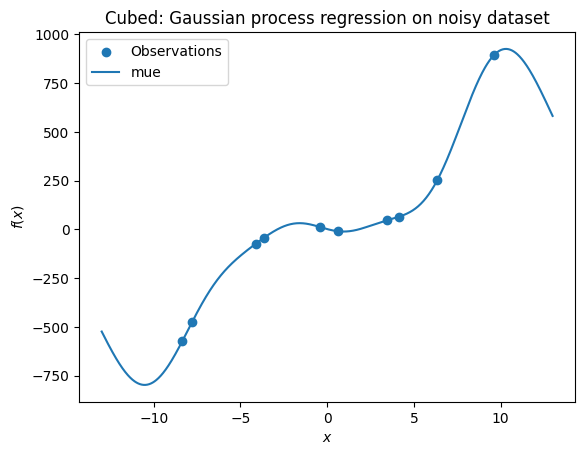

In [50]:
import numpy as np
import spotPython
from spotPython.fun.objectivefunctions import analytical
from spotPython.spot import spot
from spotPython.design.spacefilling import spacefilling
from spotPython.build.kriging import Kriging
import matplotlib.pyplot as plt

gen = spacefilling(1)
rng = np.random.RandomState(1)
lower = np.array([-10])
upper = np.array([10])
fun = analytical().fun_cubed
fun_control = {"sigma": 10,
               "seed": 123}

X = gen.scipy_lhd(10, lower=lower, upper = upper)
print(X)
y = fun(X, fun_control=fun_control)
print(y)
y.shape
X_train = X.reshape(-1,1)
y_train = y

S = Kriging(name='kriging',  seed=123, log_level=50, n_theta=1, noise=False)
S.fit(X_train, y_train)

X_axis = np.linspace(start=-13, stop=13, num=1000).reshape(-1, 1)
mean_prediction, std_prediction, ei = S.predict(X_axis, return_val="all")

plt.scatter(X_train, y_train, label="Observations")
#plt.plot(X, ei, label="Expected Improvement")
plt.plot(X_axis, mean_prediction, label="mue")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Cubed: Gaussian process regression on noisy dataset")

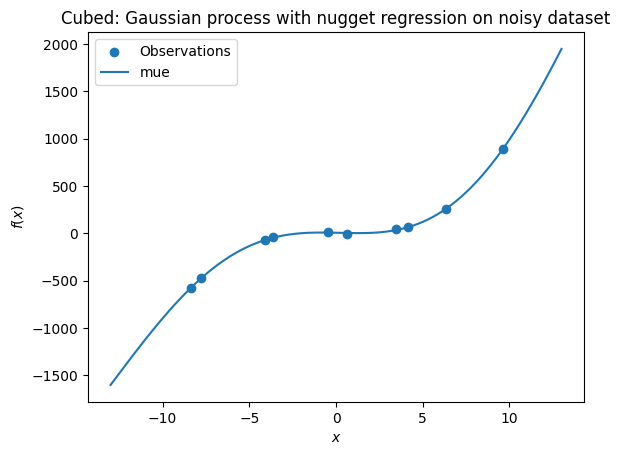

In [51]:
S = Kriging(name='kriging',  seed=123, log_level=0, n_theta=1, noise=True)
S.fit(X_train, y_train)

X_axis = np.linspace(start=-13, stop=13, num=1000).reshape(-1, 1)
mean_prediction, std_prediction, ei = S.predict(X_axis, return_val="all")

plt.scatter(X_train, y_train, label="Observations")
#plt.plot(X, ei, label="Expected Improvement")
plt.plot(X_axis, mean_prediction, label="mue")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Cubed: Gaussian process with nugget regression on noisy dataset")

[[ 0.63529627]
 [-4.10764204]
 [-0.44071975]
 [ 9.63125638]
 [-8.3518118 ]
 [-3.62418901]
 [ 4.15331   ]
 [ 3.4468512 ]
 [ 6.36049088]
 [-7.77978539]]
[ 0.46517267 -0.03599548  1.15933822  0.05915901  0.24419145  0.21502359
 -0.10432134  0.21312309 -0.05502681 -0.06434374]


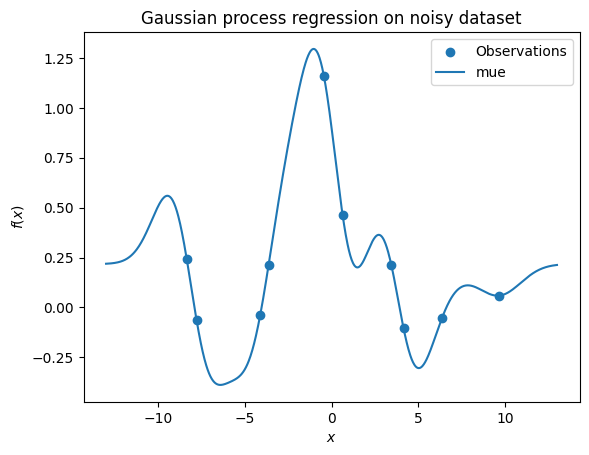

In [52]:
import numpy as np
import spotPython
from spotPython.fun.objectivefunctions import analytical
from spotPython.spot import spot
from spotPython.design.spacefilling import spacefilling
from spotPython.build.kriging import Kriging
import matplotlib.pyplot as plt

gen = spacefilling(1)
rng = np.random.RandomState(1)
lower = np.array([-10])
upper = np.array([10])
fun = analytical().fun_runge
fun_control = {"sigma": 0.25,
               "seed": 123}

X = gen.scipy_lhd(10, lower=lower, upper = upper)
print(X)
y = fun(X, fun_control=fun_control)
print(y)
y.shape
X_train = X.reshape(-1,1)
y_train = y

S = Kriging(name='kriging',  seed=123, log_level=50, n_theta=1, noise=False)
S.fit(X_train, y_train)

X_axis = np.linspace(start=-13, stop=13, num=1000).reshape(-1, 1)
mean_prediction, std_prediction, ei = S.predict(X_axis, return_val="all")

plt.scatter(X_train, y_train, label="Observations")
#plt.plot(X, ei, label="Expected Improvement")
plt.plot(X_axis, mean_prediction, label="mue")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noisy dataset")

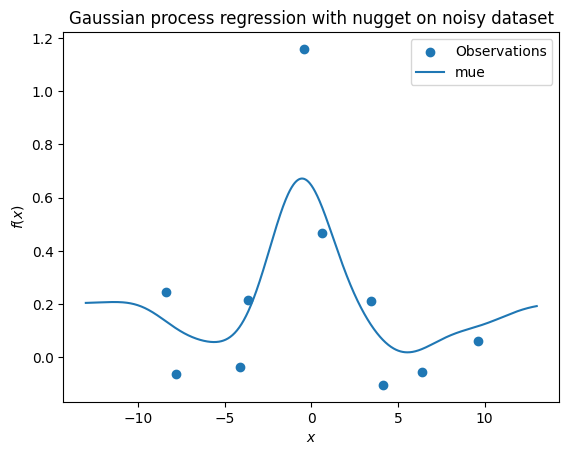

In [53]:
S = Kriging(name='kriging',
            seed=123,
            log_level=50,
            n_theta=1,
            noise=True)
S.fit(X_train, y_train)

X_axis = np.linspace(start=-13, stop=13, num=1000).reshape(-1, 1)
mean_prediction, std_prediction, ei = S.predict(X_axis, return_val="all")

plt.scatter(X_train, y_train, label="Observations")
#plt.plot(X, ei, label="Expected Improvement")
plt.plot(X_axis, mean_prediction, label="mue")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression with nugget on noisy dataset")

# Factors

In [54]:
["num"] * 3

['num', 'num', 'num']

In [55]:
from spotPython.design.spacefilling import spacefilling
from spotPython.build.kriging import Kriging
from spotPython.fun.objectivefunctions import analytical
import numpy as np

In [56]:
gen = spacefilling(2)
n = 30
rng = np.random.RandomState(1)
lower = np.array([-5,-0])
upper = np.array([10,15])
fun = analytical().fun_branin_factor
#fun = analytical(sigma=0).fun_sphere

X0 = gen.scipy_lhd(n, lower=lower, upper = upper)
X1 = np.random.randint(low=1, high=3, size=(n,))
X = np.c_[X0, X1]
y = fun(X)
S = Kriging(name='kriging',  seed=123, log_level=50, n_theta=3, noise=False, var_type=["num", "num", "num"])
S.fit(X, y)
Sf = Kriging(name='kriging',  seed=123, log_level=50, n_theta=3, noise=False, var_type=["num", "num", "factor"])
Sf.fit(X, y)
n = 50
X0 = gen.scipy_lhd(n, lower=lower, upper = upper)
X1 = np.random.randint(low=1, high=3, size=(n,))
X = np.c_[X0, X1]
y = fun(X)
s=np.sum(np.abs(S.predict(X)[0] - y))
sf=np.sum(np.abs(Sf.predict(X)[0] - y))
sf - s

-49.73942777184379

In [57]:
vars(S)

{'name': 'kriging',
 'seed': 123,
 'rng': Generator(PCG64) at 0x2BF447140,
 'log': {'negLnLike': array([73.71876494]),
  'theta': array([ 0.74260999, -0.65637563, -3.        ]),
  'p': array([2.]),
  'Lambda': array([None], dtype=object)},
 'verbosity': 50,
 'noise': False,
 'var_type': ['num', 'num', 'num'],
 'cod_type': 'norm',
 'use_cod_y': False,
 'log_level': 50,
 'sigma': 0,
 'eps': 1.4901161193847656e-08,
 'min_theta': -3,
 'max_theta': 2,
 'min_p': 1,
 'max_p': 2,
 'min_Lambda': 1e-09,
 'max_Lambda': 1.0,
 'n_theta': 3,
 'n_p': 1,
 'optim_p': False,
 'cnd_Psi': 87621328.50242156,
 'inf_Psi': False,
 'model_optimizer': <function scipy.optimize._differentialevolution.differential_evolution(func, bounds, args=(), strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, disp=False, polish=True, init='latinhypercube', atol=0, updating='immediate', workers=1, constraints=(), x0=None, *, integrality=None, vectorized=False

In [58]:
vars(Sf)

{'name': 'kriging',
 'seed': 123,
 'rng': Generator(PCG64) at 0x2BF5ED2A0,
 'log': {'negLnLike': array([97.25276865]),
  'theta': array([ 0.96025216,  0.13575231, -2.53298649]),
  'p': array([2.]),
  'Lambda': array([None], dtype=object)},
 'verbosity': 50,
 'noise': False,
 'var_type': ['num', 'num', 'factor'],
 'cod_type': 'norm',
 'use_cod_y': False,
 'log_level': 50,
 'sigma': 0,
 'eps': 1.4901161193847656e-08,
 'min_theta': -3,
 'max_theta': 2,
 'min_p': 1,
 'max_p': 2,
 'min_Lambda': 1e-09,
 'max_Lambda': 1.0,
 'n_theta': 3,
 'n_p': 1,
 'optim_p': False,
 'cnd_Psi': 53701.93611402883,
 'inf_Psi': False,
 'model_optimizer': <function scipy.optimize._differentialevolution.differential_evolution(func, bounds, args=(), strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, disp=False, polish=True, init='latinhypercube', atol=0, updating='immediate', workers=1, constraints=(), x0=None, *, integrality=None, vectorized=Fa